# Run the models using the defaults which were selected in the previous notebook

In [27]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

swissprot = pd.read_csv('../manuscript/data/reviewed_sprot_08042025.tsv', sep='\t')
data_dir = '/disk1/ariane/vscode/squidly/manuscript/AEGAN_extracted_sequences/'

def compute_uncertainties(df, prob_columns, seq_col, mean_prob=0.5, mean_var=1):
    means, variances, residues, entropy_values  = [], [], [], []
    for p1, p2, p3, p4, p5, seq in tqdm(df[prob_columns + [seq_col]].values):
        mean_values = []
        variance_values = []
        entropys = []
        indicies = []
        for j in range(0, len(seq)):
            try:
                if j > len(p1): # only go to 1024 - a limitation atm
                    mean_probs = 0
                    vars = 1 # Highlight these are incorrect
                else:
                    eps = 1e-8 # For non-zeros
                    all_probs = [p1[j] + eps, p2[j] + eps, p3[j] + eps, p4[j] + eps, p5[j] + eps]
                    mean_probs = np.mean(all_probs)
                    entropy = -((mean_probs * np.log2(mean_probs)) + ((1 - mean_probs) * np.log2(1 - mean_probs)))
                    vars = np.var(all_probs) # use variance as a proxy
                    if mean_probs > mean_prob and vars < mean_var: # Use the supplied cutoffs
                        indicies.append(j)
                mean_values.append(mean_probs)
                variance_values.append(vars)
                entropys.append(entropy)
            except:
                mean_values.append(0)
                variance_values.append(1)
                entropys.append(1)
        means.append(mean_values)
        variances.append(variance_values)
        entropy_values.append(entropys)
        residues.append('|'.join([str(s) for s in indicies]))
    return means, entropy_values, variances, residues


def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement
    predictions = []
    true = []
    missing = 0
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        res_sq = res_sq.split('|')
        if not res_pred or not isinstance(res_pred, str):
            res_pred = ''
        res_pred = res_pred.split('|')
        if len(res_pred) > 0:
            try:
                chosen_res_seq = [int(i) for i in res_pred]
            except:
                chosen_res_seq = []
                missing += 1
        res_sq = [int(i) for i in res_sq]
        for pos in range(0, len(seq)):
            if pos in res_sq:
                true.append(1)
            else:
                true.append(0)
            if pos in chosen_res_seq:
                predictions.append(1)
            else:
                predictions.append(0)
    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    return precision[1], recall[1], f1[1], support[1]


def calculate_stats_uncertainty(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    rows = []
    for seq_label, res_sq, res_pred, seq, mean_prob, alea, var in df[[id_col, true_col, pred_col, seq_col, 'mean_prob', 'entropy', 'variance']].values:
        if not res_sq:
            missing += 1
        else:
            res_sq = res_sq.split('|')
            res_sq = [int(i) for i in res_sq]
            for pos in range(0, len(seq)):
                if pos in res_sq:
                    rows.append([seq_label, pos, seq[pos], 1, mean_prob[pos], alea[pos], var[pos]])
                else:
                    rows.append([seq_label, pos, seq[pos], 0, mean_prob[pos], alea[pos], var[pos]])

    return pd.DataFrame(rows, columns=['Entry', 'Position', 'Residue', 'True Catalytic', 'Mean Prob', 'Entropy', 'Variance'])


def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['UniProtResidue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df


swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('../manuscript/data/AEGAN_real_training_set.txt', header=None)[0].values)
training_df = swissprot[swissprot['Entry'].isin(training_ids)]
training_df['Residue'] = training_df['UniProtResidue'].values

training_df.to_csv('data/AEGAN_swissprot_training.csv', index=False)
u.dp(['Number of AEGAN training set:', len(training_df)])

--------------------------------------------------------------------------------
                      Number of AEGAN training set:	9888	                       
--------------------------------------------------------------------------------


# For each of the families do the plot of the best range and then also calculate for the cutoff

In [13]:
import warnings
warnings.filterwarnings('ignore')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 158.28it/s]


--------------------------------------------------------------------------------
15B	PC	Precision: 0.8631578947368421	Recall: 0.8282828282828283	F1: 0.8453608247422681	Support: 99	
--------------------------------------------------------------------------------


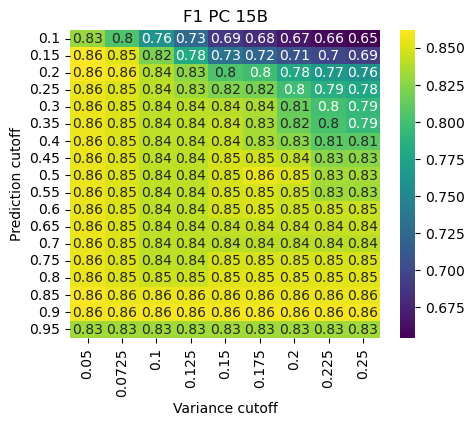

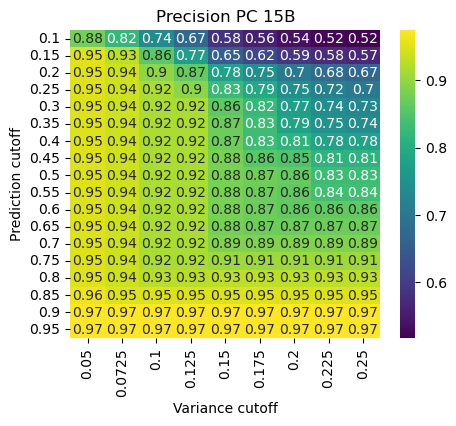

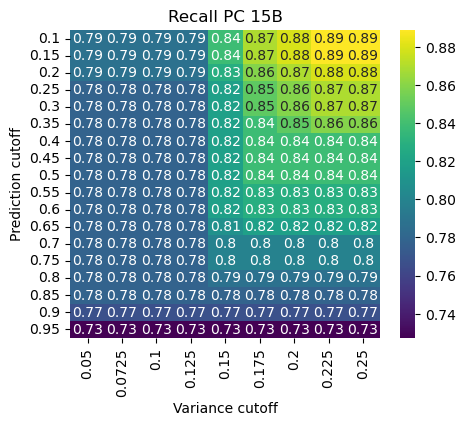

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 163.98it/s]


--------------------------------------------------------------------------------
15B	NN	Precision: 0.8723404255319149	Recall: 0.845360824742268	F1: 0.8586387434554974	Support: 194	
--------------------------------------------------------------------------------


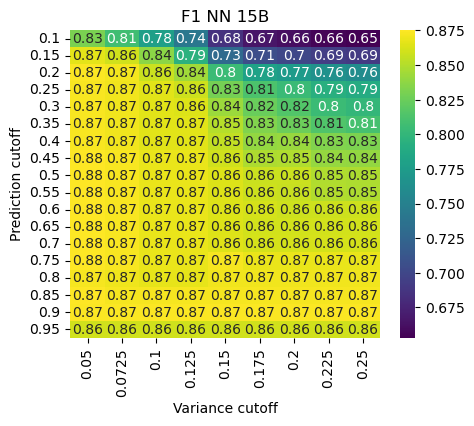

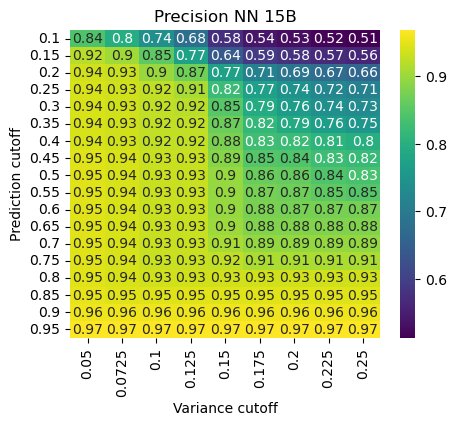

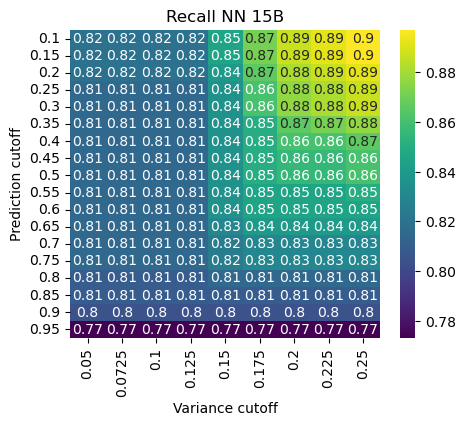

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 171.28it/s]


--------------------------------------------------------------------------------
15B	EF_superfamily	Precision: 0.9264705882352942	Recall: 0.863013698630137	F1: 0.8936170212765958	Support: 219	
--------------------------------------------------------------------------------


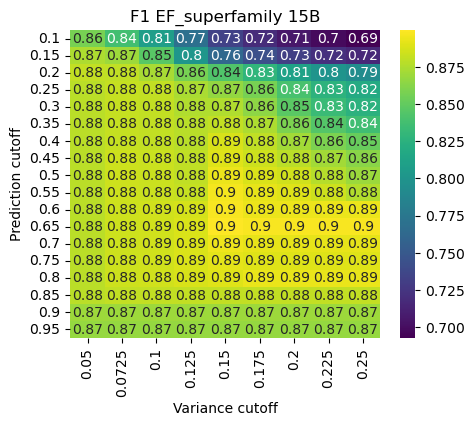

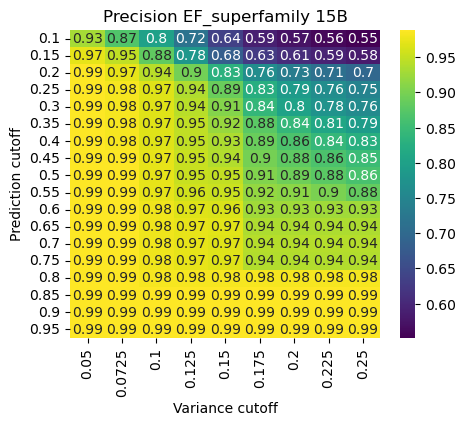

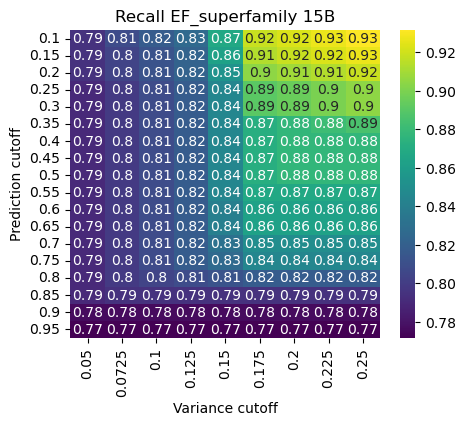

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 172.28it/s]


--------------------------------------------------------------------------------
15B	EF_fold	Precision: 0.8930817610062893	Recall: 0.8606060606060606	F1: 0.8765432098765432	Support: 165	
--------------------------------------------------------------------------------


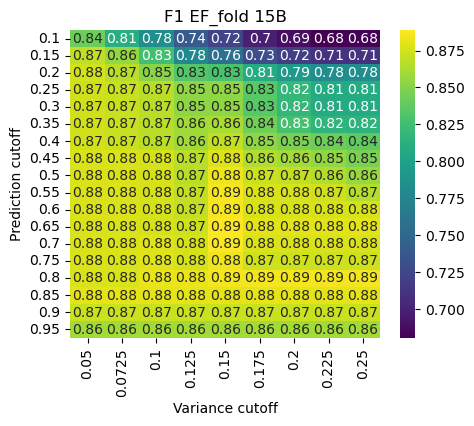

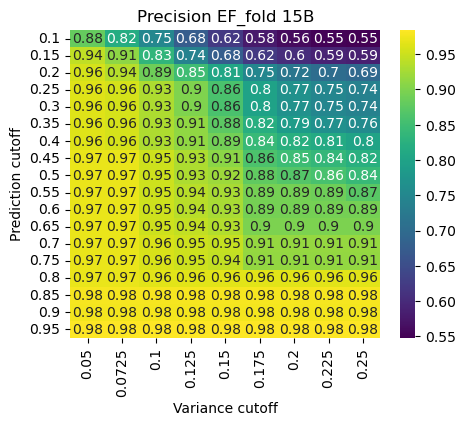

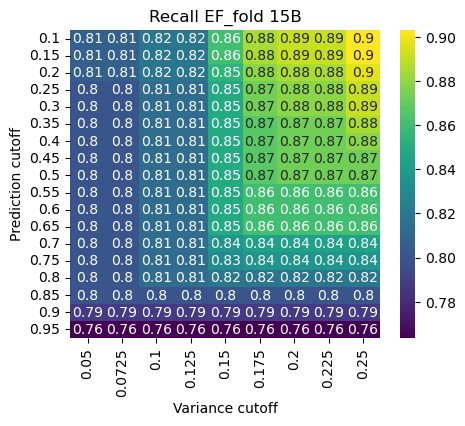

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 160.02it/s]


--------------------------------------------------------------------------------
15B	EF_family	Precision: 0.9161849710982659	Recall: 0.8590785907859079	F1: 0.8867132867132868	Support: 369	
--------------------------------------------------------------------------------


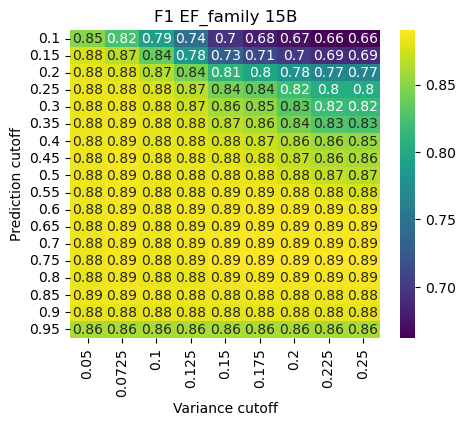

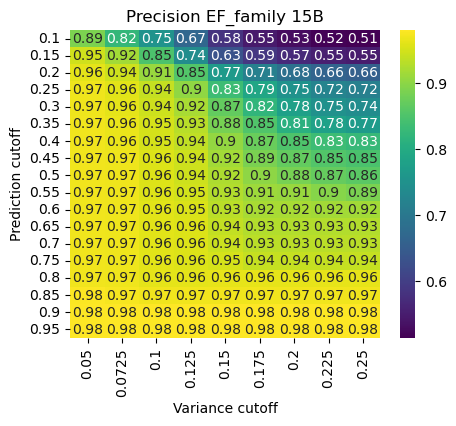

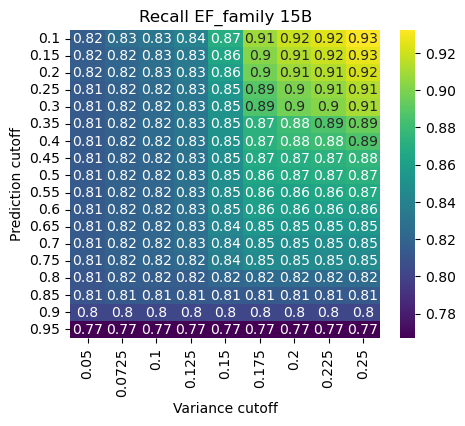

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 164.69it/s]


--------------------------------------------------------------------------------
15B	HA_superfamily	Precision: 0.870722433460076	Recall: 0.8327272727272728	F1: 0.8513011152416358	Support: 275	
--------------------------------------------------------------------------------


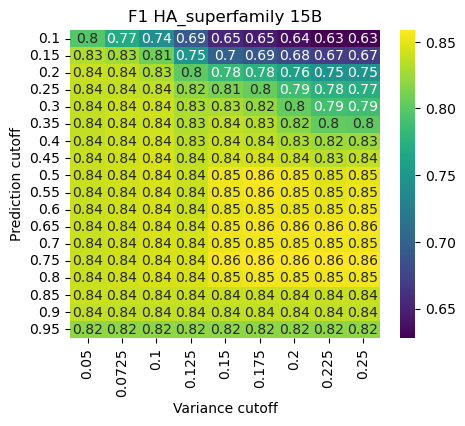

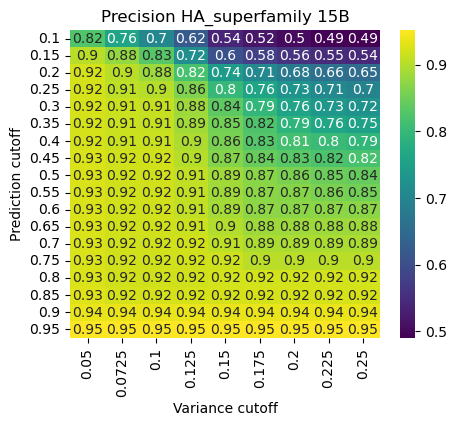

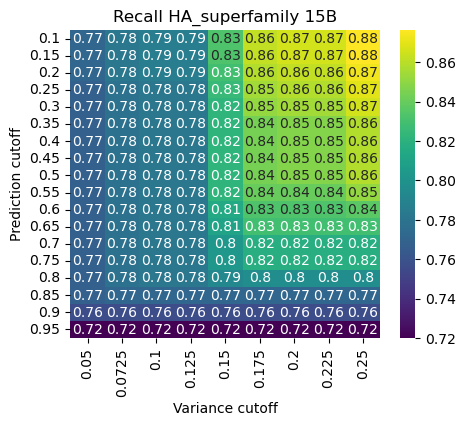

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 173.64it/s]


--------------------------------------------------------------------------------
3B	PC	Precision: 0.8631578947368421	Recall: 0.8282828282828283	F1: 0.8453608247422681	Support: 99	
--------------------------------------------------------------------------------


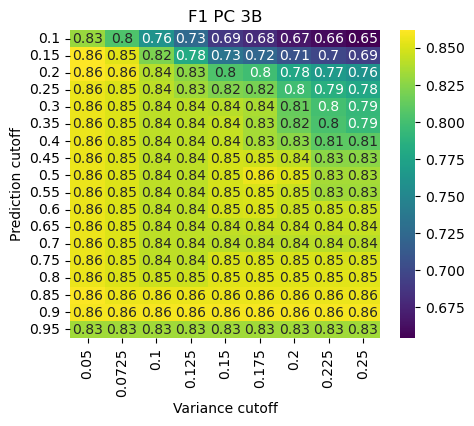

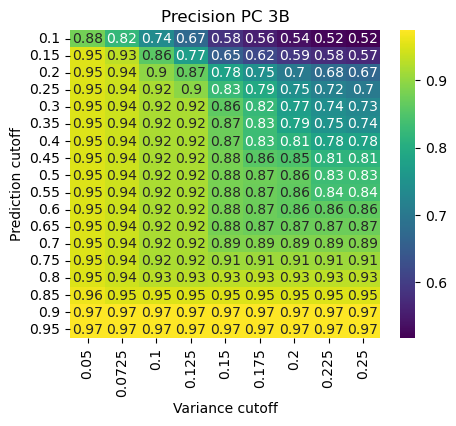

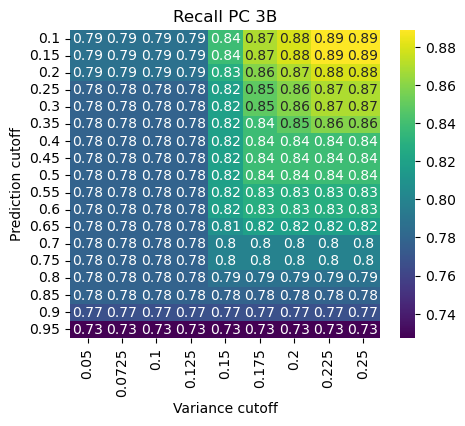

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 163.83it/s]


--------------------------------------------------------------------------------
3B	NN	Precision: 0.8723404255319149	Recall: 0.845360824742268	F1: 0.8586387434554974	Support: 194	
--------------------------------------------------------------------------------


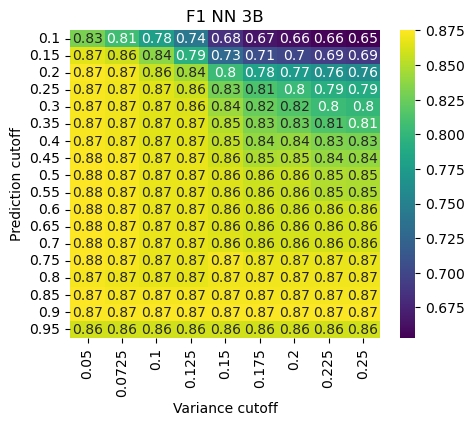

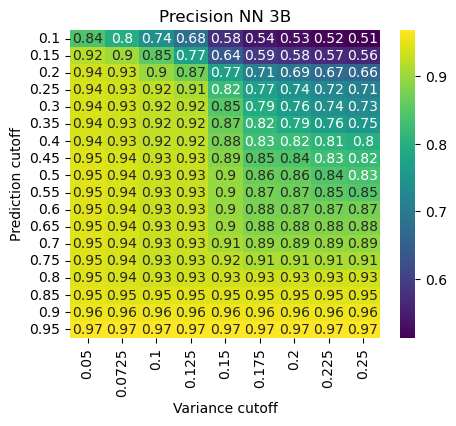

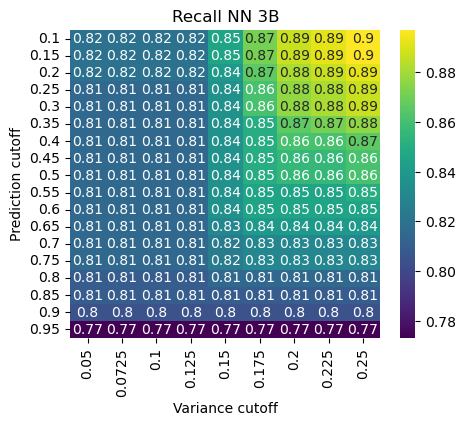

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 170.56it/s]


--------------------------------------------------------------------------------
3B	EF_superfamily	Precision: 0.9264705882352942	Recall: 0.863013698630137	F1: 0.8936170212765958	Support: 219	
--------------------------------------------------------------------------------


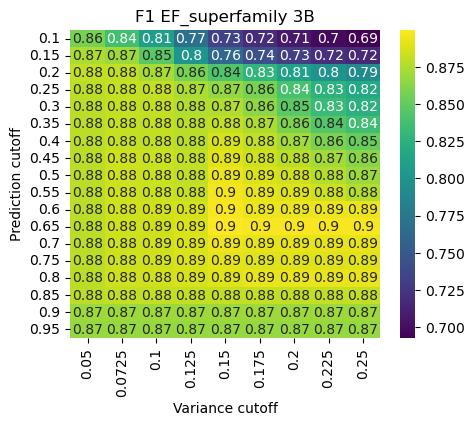

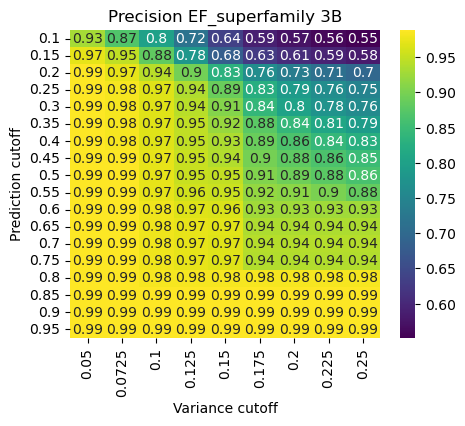

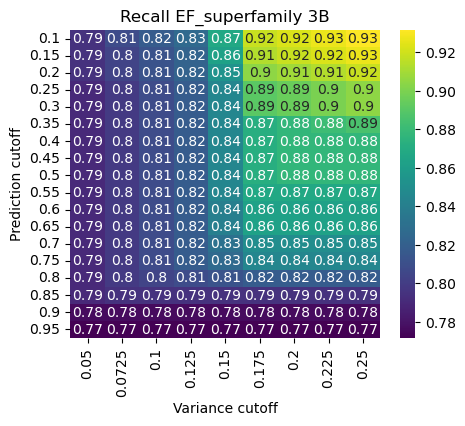

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 172.60it/s]


--------------------------------------------------------------------------------
3B	EF_fold	Precision: 0.8930817610062893	Recall: 0.8606060606060606	F1: 0.8765432098765432	Support: 165	
--------------------------------------------------------------------------------


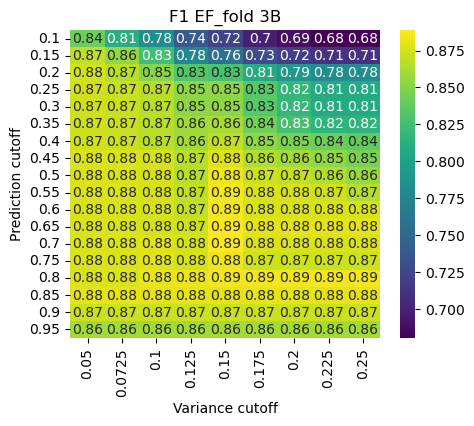

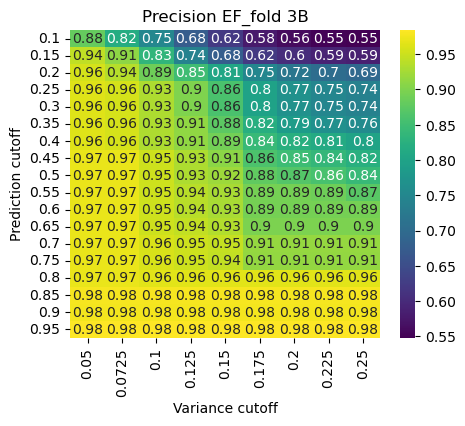

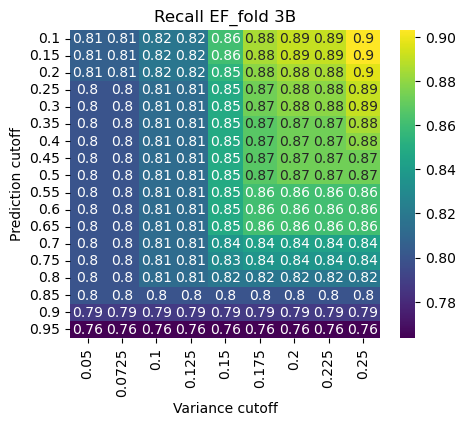

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 159.88it/s]


--------------------------------------------------------------------------------
3B	EF_family	Precision: 0.9161849710982659	Recall: 0.8590785907859079	F1: 0.8867132867132868	Support: 369	
--------------------------------------------------------------------------------


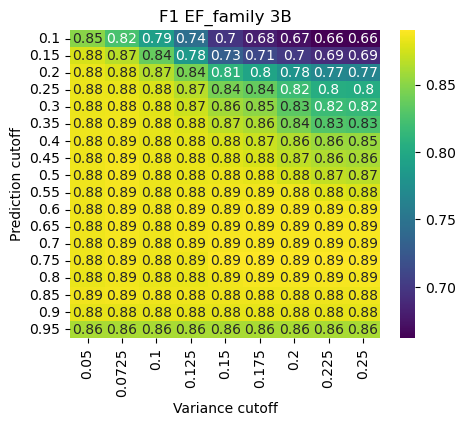

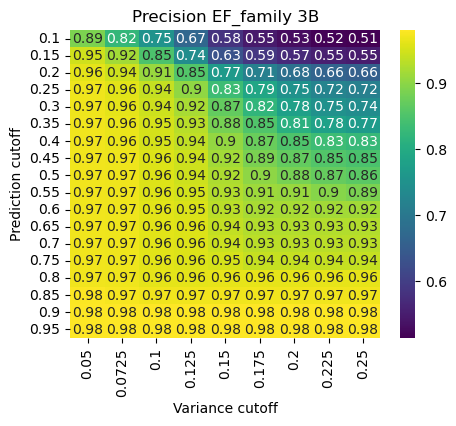

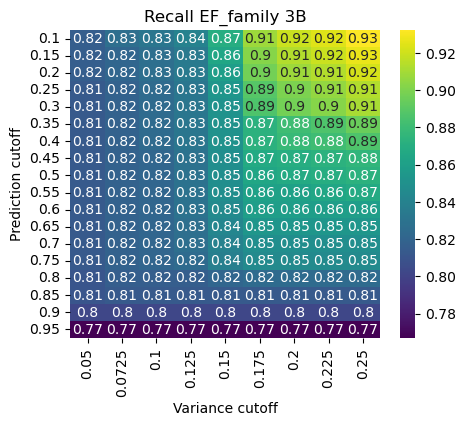

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 164.62it/s]


--------------------------------------------------------------------------------
3B	HA_superfamily	Precision: 0.870722433460076	Recall: 0.8327272727272728	F1: 0.8513011152416358	Support: 275	
--------------------------------------------------------------------------------


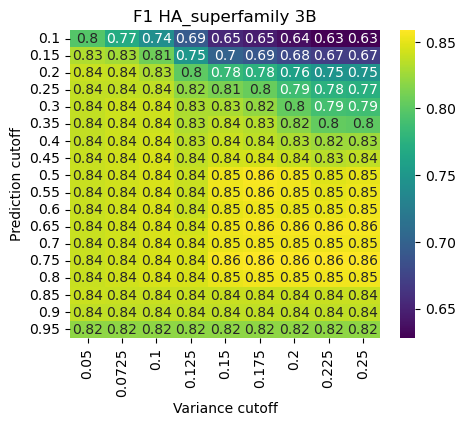

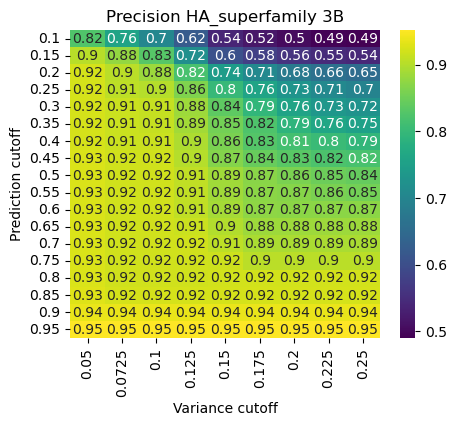

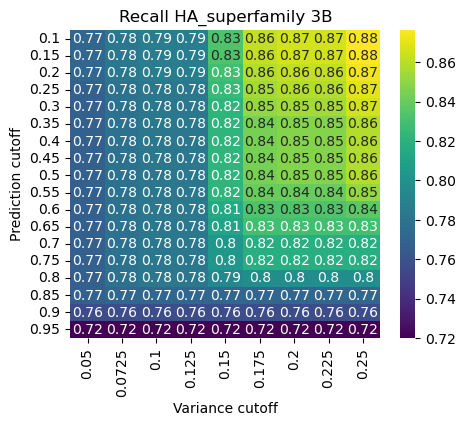

In [24]:
from tqdm import tqdm 
from collections import defaultdict
from sciutil import SciUtil
import seaborn as sns

u = SciUtil()


files = ['PC',
         'NN',
         'EF_superfamily',
         'EF_fold',
         'EF_family',
         'HA_superfamily'] 

for model in ['15B', '3B']:
    for family in files:
        # First join each of the data frames from the individual runs then compute the uncertainties 
        squidly_ensemble = pd.read_pickle(f'output/families_{b}/{family}/{family}_squidly_0.pkl')
        for model_i in range(1, 5):
            squidly_df = pd.read_pickle(f'output/families_{b}/{family}/{family}_squidly_{model_i}.pkl')
            squidly_ensemble = squidly_ensemble.join(squidly_df, how='outer', rsuffix=f'_{model_i}')
            
        squidly_ensemble.set_index('label', inplace=True)
        
        if family != 'HA_superfamily':
            squidly_ensemble['Entry'] = [e.split('|')[1] for e in squidly_ensemble.index.values]
        else:
            squidly_ensemble['Entry'] = squidly_ensemble.index.values
        squidly_ensemble.set_index('Entry', inplace=True)
        
        test_ids = set(pd.read_csv(f'{data_dir}/{family}/{family}.txt', header=None)[0].values)
        true_df = swissprot[swissprot['Entry'].isin(test_ids)]
        true_df.set_index('Entry', inplace=True)
        true_df = true_df.join(squidly_ensemble, how='left')

        true_df['label'] = true_df.index

        means, entropy_values, epistemics, residues = compute_uncertainties(true_df, ['all_AS_probs', 'all_AS_probs_1', 'all_AS_probs_2', 'all_AS_probs_3', 'all_AS_probs_4'], 'Sequence', 0.6, 0.225)
        true_df['mean_prob'] = means
        true_df['entropy'] = entropy_values
        true_df['variance'] = epistemics
        true_df['residues'] = residues    

        precision, recall, f1, support = calculate_stats(true_df, 'label', 'UniProtResidue', 'residues', 'Sequence')
    
        u.warn_p([model, family, f'Precision: {precision}', f'Recall: {recall}', f'F1: {f1}', f'Support: {support}'])
        unc_df = calculate_stats_uncertainty(true_df, 'label', 'UniProtResidue', 'residues', 'Sequence')
        cols = defaultdict(list)
        for mean_prob in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
            for vari in [0.05, 0.0725, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
                # Make a pred
                preds_prob = 1.0 * unc_df['Mean Prob'].values > mean_prob
                preds_var = 1.0 * unc_df['Variance'].values < vari
                cols[f'm{mean_prob}_v{vari}'] = 1.0*preds_prob*preds_var
        
        for c in cols:
            unc_df[c] = cols[c]
            
        # Now calculate the different predictions for each of them
        rows = []
        for c in cols:
            precision, recall, f1, support = precision_recall_fscore_support(list(unc_df['True Catalytic'].values), list(unc_df[c].values))
            # Maybe save the 0's too but for now look only at precision and recall of getting one correct
            rows.append([c, c.split('_')[0][1:], c.split('_')[1][1:], precision[1], recall[1], f1[1], support[1]])
        
        pred_df = pd.DataFrame(rows, columns=['label', 'mean_pred', 'variance', 'precision', 'recall', 'f1', 'support'])
        
        plt.rcParams['figure.figsize'] = (5,4)
        
        df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "f1"])
        pivot = df_plot.pivot("mean_pred", "variance", "f1")
        sns.heatmap(pivot, annot=True, cmap="viridis")
        plt.ylabel("Prediction cutoff")
        plt.xlabel("Variance cutoff")
        plt.title(f'F1 {family} {model}')
        plt.show()
    
        df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "precision"])
        pivot = df_plot.pivot("mean_pred", "variance", "precision")
        sns.heatmap(pivot, annot=True, cmap="viridis")
        plt.ylabel("Prediction cutoff")
        plt.xlabel("Variance cutoff")
        plt.title(f'Precision {family} {model}')
        plt.show()
    
        df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "recall"])
        pivot = df_plot.pivot("mean_pred", "variance", "recall")
        sns.heatmap(pivot, annot=True, cmap="viridis")
        plt.ylabel("Prediction cutoff")
        plt.xlabel("Variance cutoff")
        plt.title(f'Recall {family} {model}')
        plt.show()
        